In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

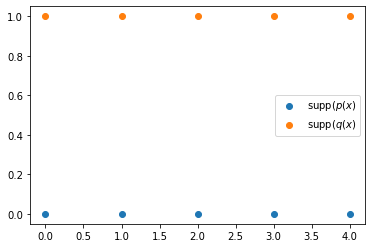

In [48]:
n_points = 5
a = np.array([[i, 0] for i in range(n_points)])
b = np.array([[i, 1] for i in range(n_points)])

plt.figure()
plt.scatter(a[:, 0], a[:, 1], label='supp($p(x)$')
plt.scatter(b[:, 0], b[:, 1], label='supp($q(x)$')
plt.legend()

In [49]:
x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

In [50]:
# Cost Matrix
p = 2
x_col = x.unsqueeze(1)
y_lin = y.unsqueeze(0)
c = torch.sum((torch.abs(x_col - y_lin)) ** 2, 2)

In [51]:
c

tensor([[ 1.,  2.,  5., 10., 17.],
        [ 2.,  1.,  2.,  5., 10.],
        [ 5.,  2.,  1.,  2.,  5.],
        [10.,  5.,  2.,  1.,  2.],
        [17., 10.,  5.,  2.,  1.]])

In [75]:
# Sinkhorn's Algorithm
mu = torch.ones(n_points,requires_grad=True) / n_points
nu = torch.ones(n_points,requires_grad=True) / n_points
epsilon = 1
K = torch.exp(-c/epsilon)

v = torch.ones(n_points)
max_niter = 100
actual_niter = 0
threshold = 1e-3
for _ in range(max_niter):
    v1 = v
    u = mu / torch.matmul(K, v)
    v = nu / torch.matmul(K.T, u)
    
    err = torch.sum(torch.abs(v-v1))
    actual_niter += 1
    if err < threshold:
        break

In [76]:
actual_niter

8

In [77]:
u

tensor([0.3725, 0.3182, 0.3232, 0.3182, 0.3725], grad_fn=<DivBackward0>)

In [78]:
v

tensor([1.0971, 0.9374, 0.9523, 0.9374, 1.0971], grad_fn=<DivBackward0>)

In [79]:
P = torch.matmul(torch.matmul(torch.diag(u), K), torch.diag(v))
P

tensor([[1.5035e-01, 4.7257e-02, 2.3901e-03, 1.5853e-05, 1.6920e-08],
        [4.7244e-02, 1.0972e-01, 4.1005e-02, 2.0096e-03, 1.5848e-05],
        [2.3890e-03, 4.0997e-02, 1.1321e-01, 4.0997e-02, 2.3890e-03],
        [1.5848e-05, 2.0096e-03, 4.1005e-02, 1.0972e-01, 4.7244e-02],
        [1.6920e-08, 1.5853e-05, 2.3901e-03, 4.7257e-02, 1.5035e-01]],
       grad_fn=<MmBackward>)

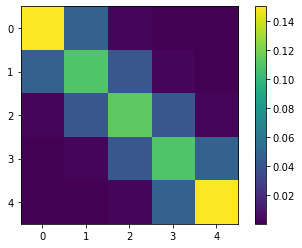

In [80]:
plt.figure()
plt.imshow(P.detach().numpy())
plt.colorbar()

In [72]:
dist = torch.sum(P * c)
dist

tensor(1.0001, grad_fn=<SumBackward0>)